# KKS Binary Solidification with FiPy
This notebook contains code for binary solidification using the
Kim-Kim-Suzuki model [1] for interfacial energy. This allows easy specification
of gamma, but requires constant chemical potential through the interface.
The implementation involves iteratively solving for chemical composition in
pure phases such that the chemical potential constraint is satisfied [2].

Questions/comments to trevor.keller@nist.gov (Trevor Keller).

References:
1. Kim, Kim, and Suzuki. "Phase-field model for binary alloys."
    _Physical Review E_ 60:6;7186-7197 (1999). 
2. Provatas and Elder. _Phase-Field Methods in Materials Science and Engineering_,
    Chapter 6, Section 9. Wiley VCH: Weinheim, Germany. 2010.


## Model Description (paraphrased after Provatas & Elder)
We are setting out to simulate solidification of two-component alloy with a lenticular phase diagram, or "binary isomorphous" system, such as Cu-Ni. The free energy curves for pure phases, $f_S$ and $f_L$, are generated from a CALPHAD database, rather than a regular solution model.

In addition to this thermodynamic description, we are adopting the KKS treatment of diffuse interfaces. This simply means that at equilibrium, chemical potential is constant through the interface, and composition varies to make it so. More concretely, composition is defined by the phase fraction $\phi$ and two fictitious concentration fields, $C_S$ and $C_L$, representing composition of the pure phase, as

$$c = h(\phi)C_S + (1-h(\phi))C_L,$$

where the interpolation function $h(\phi)=\phi^3(6\phi^2-15\phi+10)$ takes the values in solid $h(\phi=1)=1$ and liquid $h(\phi=0)=0$. At equilibrium,

$$\mu = \left.\frac{\partial f_S}{\partial c}\right|_{c=C_S} = \left.\frac{\partial f_L}{\partial c}\right|_{c=C_L}.$$

Taken together, and introducing a double-well function $g(\phi)=\phi^2(1-\phi)^2$, the thermodynamic and interfacial treatments provide the bulk free energy,

$$f(\phi,c,T) = \omega g(\phi) + h(\phi)f_S(C_S,T) + (1-h(\phi))f_L(C_L,T).$$

Now, assuming nonconserved (Allen-Cahn) dynamics for $\phi$ and conserved (Cahn-Hilliard) dynamics for $c$, we can write the equations of motion

$$\frac{\partial\phi}{\partial t} = -M_\phi\frac{\delta\mathcal{F}}{\delta\phi} \rightarrow \tau\frac{\partial\phi}{\partial t} = \epsilon_\phi^2\nabla^2\phi -\omega g'(\phi) + h'(\phi)\left[f_L(C_L) - f_S(C_S) - \frac{\partial f_L(C_L)}{\partial c}(C_L - C_S)\right]$$

$$\begin{align}
\frac{\partial c}{\partial t} = \nabla\cdot M_c\nabla\frac{\delta\mathcal{F}}{\delta c} 
  &= \nabla\cdot\left[\frac{Q(\phi)}{\frac{\partial^2 f(\phi,c)}{\partial c^2}}\nabla\left(\frac{\partial f(\phi,c)}{\partial c}\right)\right] \\
  &=\nabla\cdot\left[Q(\phi)\nabla c\right] + \nabla\cdot\left[Q(\phi)h'(\phi)(C_L-C_S)\nabla\phi\right]
\end{align}$$

with phase-dependent mobility $Q(\phi)=\frac{1-\phi}{(1+k) - (1-k)\phi}$, partition coefficient $k=\frac{C_S^e}{C_L^e}$, and time constant $\tau = M_\phi^{-1}=1$.

### The Wrinkle
$C_S$ and $C_L$ are not constants, they are field variables whose values depend on $\phi$ and $c$. Determining their values requires solving for the common tangent, or the coupled roots

$$f_1(C_S,C_L) = h(\phi)C_S + (1-h(\phi))C_L -c = 0$$

$$f_2(C_S,C_L) = \frac{\partial f_S(C_S)}{\partial c} - \frac{\partial f_L(C_L)}{\partial c} = 0.$$

While these equations can be solved using Newton's Method (cf. Provatas & Elder Appendix C.3), it's better to invoke a library, which we'll do a little later on. Even with a highly optimized root solver, determining $(C_S,C_L)$ at every grid point gets prohibitively expensive. The standard approach is to construct a lookup table for $C_S$ and $C_L$ covering $\phi=[-\delta,1+\delta]$ and $c=[-\delta,1+\delta]$ with a reasonably high number of points, then interpolating from the LUT at runtime.

## Required Libraries

In [1]:
%matplotlib inline

# high-performance mathematics and visualization
import numpy as np
from matplotlib import pyplot as plt
# Calling viewers inside display() updates them in place, rather than generating duplicate plots
from IPython import display

# curve fitting
from scipy.optimize import curve_fit, fsolve, newton
from scipy.interpolate import RectBivariateSpline

# Calphad
from pycalphad import binplot, calculate, Database, equilibrium
import pycalphad.variables as calvar

# phase field
from fipy import CellVariable, Grid1D, Grid2D, DiffusionTerm, ImplicitSourceTerm, TransientTerm, Variable
from fipy import Matplotlib1DViewer, Matplotlib2DGridViewer, MultiViewer, parallelComm
from fipy.solvers.pysparse import LinearLUSolver as Solver

## Thermodynamics
Rather than a regular solution model, we'll appeal to Calphad for free energy data. Since PyCALPHAD returns points, not curves, we'll fit the data with $10^\mathrm{th}$-order polynomials using SciPy.

In [2]:
# polynomial coefficients from curve fitting to CALPHAD at 1550 K
calCs = [0.]
calCl = [0.]

# pure equilibrium compositions (from solving dfs/dc = 0 and dfl/dc = 0)
Cse = Cle = 0.

# Generate free energy curves with PyCalphad
try:
    with open('CuNi_RWTH.tdb') as file:
        def energy(x, a, b, c, d, e, f, g, h, i, j, k):
            return a*x**10 + b*x**9 + c*x**8 + d*x**7 + e*x**6 + \
                   f*x**5 + g*x**4 + h*x**3 + i*x**2 + j*x + k
        def chempot(x, a, b, c, d, e, f, g, h, i, j):
            return 10*a*x**9 + 9*b*x**8 + 8*c*x**7 + 7*d*x**6 + 6*e*x**5 + \
                    5*f*x**4 + 4*g*x**3 + 3*h*x**2 + 2*i*x + j

        # Import the database
        Vm = 7.124e-4
        copperNickelCalphadDatabase = Database('CuNi_RWTH.tdb')
        Gs = calculate(copperNickelCalphadDatabase, ['CU', 'NI', 'VA'], 'FCC_A1', T=1550, output='GM')
        xs = np.ravel(Gs.X.sel(component='NI'))
        ys = np.ravel(Vm * Gs.GM)
        calCs, pcov = curve_fit(energy, xs, ys)
        
        Gl = calculate(copperNickelCalphadDatabase, ['CU', 'NI', 'VA'], 'LIQUID', T=1550, output='GM')
        xl = np.ravel(Gl.X.sel(component='NI'))
        yl = np.ravel(Vm * Gl.GM)
        calCl, pcov = curve_fit(energy, xl, yl)


except IOError as e:
    print "CALPHAD database file not found, assuming defaults."
    calCs = [6.19383857e+03,-3.09926825e+04, 6.69261368e+04,-8.16668934e+04, \
             6.19902973e+04,-3.04134700e+04, 9.74968659e+03,-2.04529002e+03, \
             2.95622845e+02,-3.70962613e+01,-6.12900561e+01]

    calCl = [6.18692878e+03,-3.09579439e+04, 6.68516329e+04,-8.15779791e+04, \
             6.19257214e+04,-3.03841489e+04, 9.74145735e+03,-2.04379606e+03, \
             2.94796431e+02,-3.39127135e+01,-6.26373908e+01]

In [3]:
# bulk free energy curves
def fS(c_):
    return   calCs[0]*c_**10 + calCs[1]*c_**9 + calCs[2]*c_**8 + calCs[3]*c_**7 \
           + calCs[4]*c_**6  + calCs[5]*c_**5 + calCs[6]*c_**4 + calCs[7]*c_**3 \
           + calCs[8]*c_**2  + calCs[9]*c_    + calCs[10]

def fL(c_):
    return   calCl[0]*c_**10 + calCl[1]*c_**9 + calCl[2]*c_**8 + calCl[3]*c_**7 \
           + calCl[4]*c_**6  + calCl[5]*c_**5 + calCl[6]*c_**4 + calCl[7]*c_**3 \
           + calCl[8]*c_**2  + calCl[9]*c_    + calCl[10]

# first derivatives
def dfSdc(c_):
    return  10.0*calCs[0]*c_**9 + 9.0*calCs[1]*c_**8 + 8.0*calCs[2]*c_**7 \
           + 7.0*calCs[3]*c_**6 + 6.0*calCs[4]*c_**5 + 5.0*calCs[5]*c_**4 \
           + 4.0*calCs[6]*c_**3 + 3.0*calCs[7]*c_**2 + 2.0*calCs[8]*c_ + calCs[9];

def dfLdc(c_):
    return  10.0*calCl[0]*c_**9 + 9.0*calCl[1]*c_**8 + 8.0*calCl[2]*c_**7 \
           + 7.0*calCl[3]*c_**6 + 6.0*calCl[4]*c_**5 + 5.0*calCl[5]*c_**4 \
           + 4.0*calCl[6]*c_**3 + 3.0*calCl[7]*c_**2 + 2.0*calCl[8]*c_ + calCl[9];
            
# second derivatives
def d2fSdc2(c_):
    return   90.0*calCs[0]*c_**8 + 72.0*calCs[1]*c_**7 + 56.0*calCs[2]*c_**6 \
           + 42.0*calCs[3]*c_**5 + 30.0*calCs[4]*c_**4 + 20.0*calCs[5]*c_**3 \
           + 12.0*calCs[6]*c_**2 +  6.0*calCs[7]*c_    +  2.0*calCs[8]

def d2fLdc2(c_):
    return   90.0*calCl[0]*c_**8 + 72.0*calCl[1]*c_**7 + 56.0*calCl[2]*c_**6 \
           + 42.0*calCl[3]*c_**5 + 30.0*calCl[4]*c_**4 + 20.0*calCl[5]*c_**3 \
           + 12.0*calCl[6]*c_**2 +  6.0*calCl[7]*c_    +  2.0*calCl[8]

In [4]:
# Interpolation function
def h(phi_):
    return phi_
    #return phi_**3 * (6. * phi_**2 - 15. * phi_ + 10.)

def hprime(phi_):
    return 1.
    #return 30. * phi_**2 * (1. - phi_)**2
    
# Double well function
def g(phi_):
    return phi_**2 * (1. - phi_)**2

def gprime(phi_):
    return 2. * phi_ * (1. - phi_) * (1. - 2.*phi_)

# Linearized functions for implicit source term
def linearHprime(phi_):
    return 30. * phi_ * (1. - phi_)
def linearHdoublePrime(phi_):
    return 30. * (1. - 2. * phi_)

def linearGprime(phi_):
    return 2. * (1. - 2. * phi_)
def linearGdoublePrime(phi_):
    return -4.

### Plot phase diagram and free energy curves

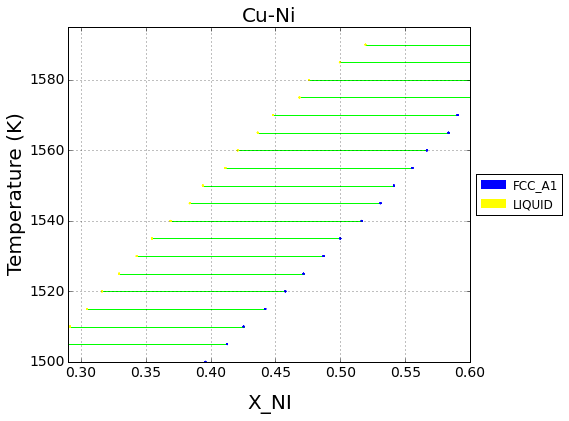

In [5]:
try:
    with open('CuNi_RWTH.tdb') as file:
        # load the CALPHAD database
        copperNickelCalphadDatabase = Database('CuNi_RWTH.tdb')
        knownPhases = ['FCC_A1', 'LIQUID', 'BCC_A2', 'HCP_A3']
        fig = plt.figure(figsize=(9,6))
        # create the equilibrium isobaric phase diagram for inspection
        isoP = 101325 # Pascal
        binplot(copperNickelCalphadDatabase, ['CU', 'NI', 'VA'] , knownPhases, \
                {calvar.X('NI'):(0.3, 0.6, 0.01),  calvar.T:(1500, 1600, 5), calvar.P:isoP}, \
                ax=fig.gca())
        plt.show()
        # locate the isothermal isobaric liquidus and solidus compositions
        # NOTE: equilibrium calculations over a dense test range is expensive.
        #       Check the coded values of Cle and Cse against the diagram, and
        #       regenerate if they deviate, or you've changed temperature, or 
        #       want a higher- or lower-resolution estimate.
        isoT = 1550 # Kelvin
        if isoT != 1550:
            liquidus = equilibrium(copperNickelCalphadDatabase, ['CU', 'NI', 'VA'], knownPhases, \
                              {calvar.X('NI'):(0.375, 0.400, 0.0001),  calvar.T:isoT, calvar.P:isoP})
            mask = np.logical_and.reduce(liquidus.Phase == ['LIQUID','FCC_A1'], axis=3)
            Cle = float(np.min(liquidus.Phase.X_NI[mask[0,0]]))
            
            solidus = equilibrium(copperNickelCalphadDatabase, ['CU', 'NI', 'VA'], knownPhases, \
                              {calvar.X('NI'):(0.525, 0.550, 0.0001), calvar.T:isoT, calvar.P:isoP})
            mask = np.logical_and.reduce(solidus.Phase == ['LIQUID','FCC_A1'], axis=3)
            Cse = float(np.max(solidus.Phase.X_NI[mask[0,0]]))
        else:
            Cse = 0.5413
            Cle = 0.3940
except IOError as e:
    print "No thermodynamics database found."
    Cse = 0.5413
    Cle = 0.3940
    

In [6]:
eqPartitionCoefficient = Cse / Cle
print 'At equilibrium, Cl=',Cle, ', Cs=',Cse, ', k=',eqPartitionCoefficient

At equilibrium, Cl= 0.394 , Cs= 0.5413 , k= 1.37385786802


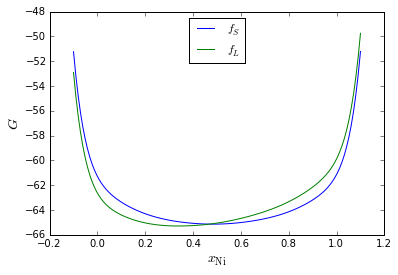

In [7]:
w = np.linspace(-0.1,1.1,125)
plt.plot(w, fS(w), label=('$f_S$'))
plt.plot(w, fL(w), label=('$f_L$'))
plt.xlabel('$x_\mathrm{Ni}$',fontsize=14)
plt.ylabel('$G$',fontsize=14)
plt.legend(loc=9)

## Fictitious composition fields
$C_S$ and $C_L$ are computed using the thermodynamic potentials for pure phases ($f_S$ and $f_L$), interpolation and double-well functions, and a weighting function.

### Common Tangent solution
We should have everything we need to compute self-consistent values of $C_S$ and $C_L$ given $\phi$ and $c$. Instead of coding Newton's Method by hand, we'll use ```scipy.optimize```, which has excellent libraries for root finding. This follows the approach set forth in FiPy's [```examples.phase.binaryCoupled```](http://www.ctcms.nist.gov/fipy/examples/phase/generated/examples.phase.binaryCoupled.html) code. To use it, we'll feed in the coupled equations

$$ f_1(C_S,C_L) = h(\phi)C_S + (1-h(\phi))C_L -c $$
$$ f_2(C_S,C_L) = \frac{\partial f_S(C_S)}{\partial c} - \frac{\partial f_L(C_L)}{\partial c} $$

and the Jacobian matrix to accelerate convergence,

$$ \mathbf{J} = \left[\begin{array}{c} 
    \frac{\partial f_1}{\partial C_S} & \frac{\partial f_1}{\partial C_L}\\
    \frac{\partial f_2}{\partial C_S} & \frac{\partial f_2}{\partial C_L}
\end{array}\right]  = \left[\begin{array}{c} 
    h(\phi) & 1-h(\phi)\\
    \frac{\partial^2 f_S(C_S)}{\partial c^2} & -\frac{\partial^2 f_L(C_L)}{\partial c^2}
\end{array}\right]. $$

In [8]:
def commonTangentConc(phi_, c_, guessCs, guessCl):
    def equilibrium(C):
        return [h(phi_) * C[0] + (1. - h(phi_)) * C[1] - c_,
                dfSdc(C[0]) - dfLdc(C[1])                 ]
    
    def equilibriumJacobian(C):
        return [ [ h(phi_)       , 1. - h(phi_)  ],
                 [ d2fSdc2(C[0]), -d2fLdc2(C[1])] ]
    # Return the tuple (CsRoot, ClRoot)
    return fsolve(func=equilibrium, x0=[guessCs, guessCl],
                  fprime=equilibriumJacobian)

## Read or Generate Lookup Table (LUT)
The fictitious single-phase composition fields $(C_S, C_L)$ are expensive to compute at runtime. Therefore, a LUT is generated offline for quick access to close approximations for the $(\phi,c)$ values at each grid point. This should be written as a tab-delimited table (TSV) of coordinates $(\phi,c)$ and values $(C_S,C_L)$.

In [9]:
# If any parameters affecting the free energy landscape change, the LUT must be re-generated.
# Un-comment the following line to delete it.
#!rm consistentC.npz

In [10]:
# Provide number of mesh points and mesh spacing for LUT.
# Provide two extra spaces per dimension for a point less than zero and greater than one.
# This enables interpolation at zero and one.
LUTnp = LUTnc = 1002
LUTdp = LUTdc = 1. / (LUTnp - 2)

# Attempt to open consistentC.npz. If it does not exist, create it. 
try:
    with open('consistentC.npz') as file:
        # LUT already exists: no need to generate
        pass
except IOError as e:
    print "Lookup table does not exist: generating from scratch. This should finish within 5 minutes."
    
    # create a mesh over phi and c, 125x125 points
    pureCs = np.zeros(LUTnp * LUTnc).reshape(LUTnp, LUTnc)
    pureCl = np.zeros(LUTnp * LUTnc).reshape(LUTnp, LUTnc)
    
    # iterate over the LUT, ignore stored value
    for (x,y), z in np.ndenumerate(pureCs):
        LUTp = (x - 1) * LUTdp
        LUTc = (y - 1) * LUTdc
        pureCs[x, y], pureCl[x, y] = commonTangentConc(LUTp, LUTc, LUTc, LUTc)
    
    # export Cs, Cl to compressed NumPy format
    np.savez_compressed('consistentC.npz', Cs=pureCs, Cl=pureCl)
    

# LUT either already existed, or has now been written to disk. Read it into memory.
LUTdict = np.load('consistentC.npz')
pureCs = LUTdict['Cs'].reshape(LUTnp, LUTnc)
pureCl = LUTdict['Cl'].reshape(LUTnp, LUTnc)

# Generate interpolation functions for Cs, Cl
LUTp = np.linspace(-LUTdp, 1. + LUTdp, LUTnp)
LUTc = np.linspace(-LUTdc, 1. + LUTdc, LUTnc)

interpolateCs = RectBivariateSpline(LUTp, LUTc, pureCs, bbox=[-LUTdp, 1. + LUTdp, -LUTdc, 1. + LUTdc])
interpolateCl = RectBivariateSpline(LUTp, LUTc, pureCl, bbox=[-LUTdp, 1. + LUTdp, -LUTdc, 1. + LUTdc])

### Visualize the table
$C_S$ and $C_L$ should vary smoothly over the domain, with the fingerprint of your interpolation function $h(\phi)$ plainly visible.

<matplotlib.colorbar.Colorbar instance at 0x7fb4ec39fe60>

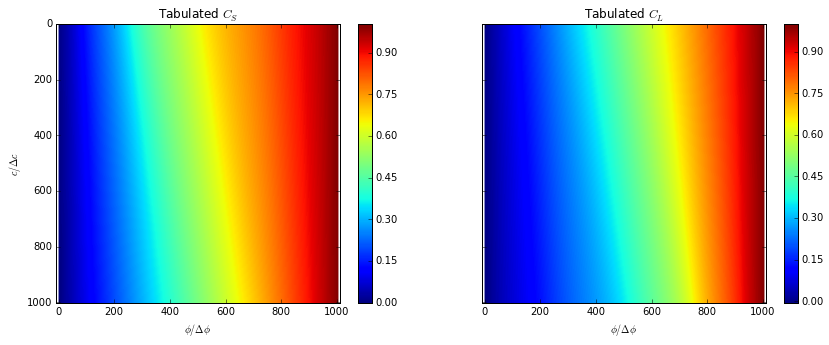

In [11]:
# Invoke Matplotlib directly to plot Cs, Cl side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(14,5))

pltCs = ax1.imshow(pureCs)
ax1.set_title('Tabulated $C_S$')
ax1.set_xlabel('$\phi/\Delta\phi$')
ax1.set_ylabel('$c/\Delta c$')
plt.colorbar(pltCs, ax=ax1)

pltCl = ax2.imshow(pureCl)
ax2.set_title('Tabulated $C_L$')
ax2.set_xlabel('$\phi/\Delta\phi$')
plt.colorbar(pltCl, ax=ax2)

# Finally, the science

## Equation of Motion: Phase Field
$$ \underbrace{\frac{\partial\phi}{\partial t}}_{\text{TransientTerm}} \
   = \underbrace{\epsilon_\phi^2\nabla^2\phi}_{\text{DiffusionTerm}} \
   - \underbrace{\omega g'(\phi) + h'(\phi)\left(f_L(C_L) - f_S(C_S) - \frac{\partial f_L(C_L)}{\partial c}(C_L - C_S)\right)}_{\text{source to be linearized}}$$

This discretization proceeds nearly identically to [```examples.phase.simple```](http://www.ctcms.nist.gov/fipy/examples/phase/generated/examples.phase.simple.html). The source term is linearized as follows.

$$ \begin{align}
 \mu_c &= f_L(C_L) - f_S(C_S) - \frac{\partial f_L(C_L)}{\partial c}(C_L - C_S) \\
 S &=       -\omega g'(\phi)                 + h'(\phi)\mu_c \\
   &= \left[-\omega g_\ell'(\phi)\phi(1-\phi) + h_\ell'(\phi)\mu_c\phi(1-\phi)\right] \\
   &= \left[-\omega g_\ell'(\phi)            + h_\ell'(\phi)\mu_c\right]\phi(1-\phi) \\
   &= m_\phi \phi(1-\phi) \\
 m_\phi &= -\omega g_\ell'(\phi)             + h_\ell'(\phi)\mu_c
 \end{align}$$
 
with the linearized functions $g_\ell'(\phi)$ and $h_\ell'(\phi)$ defined by the expressions $g'(\phi)=\phi(1-\phi)g_\ell'(\phi)$ and $h'(\phi)=\phi(1-\phi)h_\ell'(\phi)$. Using the Taylor series expansion about $\phi_{\mathrm{old}}$, the source can be represented $S = S_0 + S_1\phi$ with $S_1 = \left.\frac{\partial S}{\partial\phi}\right|_{\mathrm{old}}$ and $S_0 = S_{\mathrm{old}} - S_1\phi_{\mathrm{old}}$ with
 
 $$ \begin{align}
    \frac{\partial S}{\partial\phi} &= \frac{\partial m_\phi}{\partial\phi}\phi(1-\phi) + m_\phi(1-2\phi)\\
    \frac{\partial m_\phi}{\partial\phi} &= -\omega g_\ell''(\phi) + h_\ell''(\phi)\mu_c \\
    S_1 &= \frac{\partial m_\phi}{\partial\phi}\phi(1-\phi) + m_\phi(1-2\phi) \\
    S_0 &= m_\phi\phi(1-\phi) - S_1\phi.
    \end{align}$$
    
In order to re-use the equation for 1D and 2D meshes, we'll define a function to build it.

In [12]:
epsSq = 1.25        # gradient penalty coefficient
halfWidth = 5.0 # half the interface thickness
def omega(spacing):
    return 2. * epsSq * (2.5 / (halfWidth*spacing))**2

def buildPhaseEquation(phi_, Cs_, Cl_):
    diffusionPotential = fL(Cl_) - fS(Cs_) - dfLdc(Cl_) * (Cl_ - Cs_)
    mPhi = -omega(phi_.mesh.dx) * linearGprime(phi_) + linearHprime(phi_) * diffusionPotential

    dmPhidPhi = -omega(phi_.mesh.dx) * linearGdoublePrime(phi_) + linearHdoublePrime(phi_) * diffusionPotential
    S1 = dmPhidPhi * phi_ * (1. - phi_) + mPhi * (1. - 2. * phi_)
    S0 = mPhi * phi_ * (1. - phi_) - S1 * phi_

    return (TransientTerm(var=phi_) == DiffusionTerm(coeff=epsSq, var=phi_) \
                                     + S0 + ImplicitSourceTerm(coeff=S1, var=phi_))

## Equation of Motion: Concentration Field
$$ \underbrace{\frac{\partial c}{\partial t}}_{\text{TransientTerm}} \
   = \underbrace{\nabla\cdot\left[Q(\phi)\nabla c\right]}_{\text{DiffusionTerm}} \
   + \underbrace{\nabla\cdot\left[Q(\phi)h'(\phi)(C_L-C_S)\nabla\phi\right]}_{\text{explicit source term}}
   $$

with solid diffusivity $D_S = Q(\phi) h(\phi)$, liquid diffusivity $D_L = Q(\phi) (1-h(\phi))$, phase-dependent mobility $Q(\phi)=\frac{1-\phi}{(1+k) - (1-k)\phi}$, partition coefficient $k=\frac{C_S}{C_L}$.

The FiPy manual is very clear that while the last term is a diffusion term, it is not a ```DiffusionTerm``` since its dependent variable is $\phi$ rather than $c$.

In [13]:
def buildConcEquation(phi_, c_, Cs_, Cl_):
    def Q(phi_, Cs_, Cl_):
        Qmin = 0.01
        return  Qmin + (1. - Qmin) * (1.-phi_) / \
                       (1. + eqPartitionCoefficient \
                     - (1. - eqPartitionCoefficient) * phi_)
    
    Dc = Q(phi_, Cs_, Cl_)
    Dp = Q(phi_, Cs_, Cl_) * hprime(phi_) * (Cl_ - Cs_)
    
    return (TransientTerm(var=c_) == DiffusionTerm(coeff=Dc, var=c_) \
                                   + (Dp.arithmeticFaceValue * (phi_.faceGrad)).divergence)

# Reusable Initialization and Evolution Code
For convenience, we'll wrap the time-stepping code in a function.

In [14]:
initConc = Cle + 0.50 * (Cse - Cle)

def initPlanar(phase, conc, Cs, Cl):
    x = phase.mesh.cellCenters
    # Flat field initializations
    phase.setValue( 0. )
    conc.setValue( initConc )
    # Solid on the left, Liquid on the right
    mask = (x <  phase.mesh.nx * phase.mesh.dx / 8)
    phase.setValue(1., where=mask)
    # Interpolate Cs and Cl using the initialized values
    Cs.value = interpolateCs(phase, conc, grid=False)
    Cl.value = interpolateCl(phase, conc, grid=False)


def initCircular(phase, conc, Cs, Cl, circles):    
    x, y = phase.mesh.cellCenters
    # Flat field initializations
    phase.setValue( 0. )
    conc.setValue( initConc )
    # Pass in a list of (x0, y0, r) tuples as "circles", e.g.
    #           x center         y center      radius
    #circles = [(0.333 * nx * dx, (ny-2-10) * dy, 10. * dx), \
    #           (0.750 * nx * dx, (ny-2-8) * dy, 8. * dx)]
    for (x0, y0, r) in circles:
        mask = (x - x0)**2 + (y - y0)**2 < r**2
        phase.setValue(1., where=mask)
    # Interpolate Cs and Cl using the initialized values
    Cs.value = interpolateCs(phase, conc, grid=False)
    Cl.value = interpolateCl(phase, conc, grid=False)

In [15]:
# Helmholtz free energy density
def freeEnergyDensity(phi_, c_, Cs_, Cl_):
    return 0.5 * epsSq * (phi_.grad)**2 \
           + omega(phi_.mesh.dx) * g(phi_) + h(phi_) * fS(Cs_) + (1.-h(phi_)) * fL(Cl_)

def evolveInTime(phase, conc, Cs, Cl, viewer, \
               phaseEq, concEq, solver, dt, dV, \
               solidHistory, massHistory, chemHistory, cflHistory, \
               totalTime, currentStep, totalSteps, \
               dataDirectory):
    sweepLimit = 2
    tolerance = 0.05
    
    while currentStep.value < totalSteps:
        phase.updateOld()
        conc.updateOld()
        Cs.updateOld()
        Cl.updateOld()

        phaseResidual0 = phaseEq.sweep(phase, dt=dt.value, solver=solver)
        concResidual0  =  concEq.sweep(conc , dt=dt.value, solver=solver)

        for sweep in range(sweepLimit):
            phaseResidual = phaseEq.sweep(phase, dt=dt.value, solver=solver)
            concResidual  =  concEq.sweep(conc,  dt=dt.value, solver=solver)
            # Interpolate Cs and Cl using the new values
            Cs.value = interpolateCs(phase, conc, grid=False)
            Cl.value = interpolateCl(phase, conc, grid=False)

        if parallelComm.procID == 0:
            print "Step {0}: dt={1:.2e},\t phase res={2:.2e} -> {3:.2e},\t conc res={4:.2e} -> {5:.2e}" \
                  .format(currentStep, float(dt.value), \
                          phaseResidual0, phaseResidual, \
                          concResidual0, concResidual)

        if (phaseResidual < phaseResidual0 * tolerance) and (concResidual < concResidual0 * tolerance):
            currentStep.setValue(currentStep.value + 1)
            totalTime.append(totalTime[-1] + dt.value)
            glp = np.array(phase.globalValue)
            glc = np.array(conc.globalValue)
            glcs = np.array(Cs.globalValue)
            glcl = np.array(Cl.globalValue)
            solidHistory.append( (glp > 0.5).sum() * dV )
            massHistory.append( glc.sum() * dV )
            chemHistory.append( np.linalg.norm((fL(glcl) - fS(glcs))/(Cle - Cse))/np.sqrt(phase.mesh.numberOfCells) )
            mask = np.array([glp>0.3, glp<0.7]).all()
            glv = np.array(((glp[mask] - phase.old.globalValue[mask]) \
                            / (dt.value * phase.grad.mag.globalValue[mask])))
            cflHistory.append(dt.value * np.max(glv) / phase.mesh.dx)
            dt.setValue(dt.value * 1.1)
            if currentStep % 10 == 0:
                display.display(viewer.plot())
            #if currentStep % 10000 == 0:
            #    if parallelComm.procID == 0:
            #        np.savez_compressed('{0}/dump{1}.npz'.format(dataDirectory, currentStep), \
            #                            phase=glp, \
            #                            conc=glc, \
            #                            Cs=glcs, \
            #                            Cl=glcl, \
            #                            elapsedTime=np.array(totalTime[-1]))
        else:
            dt.setValue(dt.value * 0.8)
            phase[:] = phase.old
            conc[:] = conc.old
            Cs[:] = Cs.old
            Cl[:] = Cl.old

## Sanity Check: 1D

### Build the mesh, define field variables

In [16]:
# Spatial parameters
dx1 = 0.075    # mesh resolution
nx1 = 512 # domain size

# 1D Grid
mesh1D = Grid1D(nx=nx1, dx=dx1)
dV1 = dx1

# Scalar fields
phase1 = CellVariable(mesh=mesh1D, hasOld=True)
conc1  = CellVariable(mesh=mesh1D, hasOld=True)
Cs1    = CellVariable(mesh=mesh1D, hasOld=True)
Cl1    = CellVariable(mesh=mesh1D, hasOld=True)

# Equations of motion
phaseEq1 = buildPhaseEquation(phase1, Cs1, Cl1)
concEq1 =  buildConcEquation(phase1, conc1, Cs1, Cl1)

### Clear old files, initialize grid and viewer

rm: cannot remove ‘data/FiPy/1D/dump*.npz’: No such file or directory


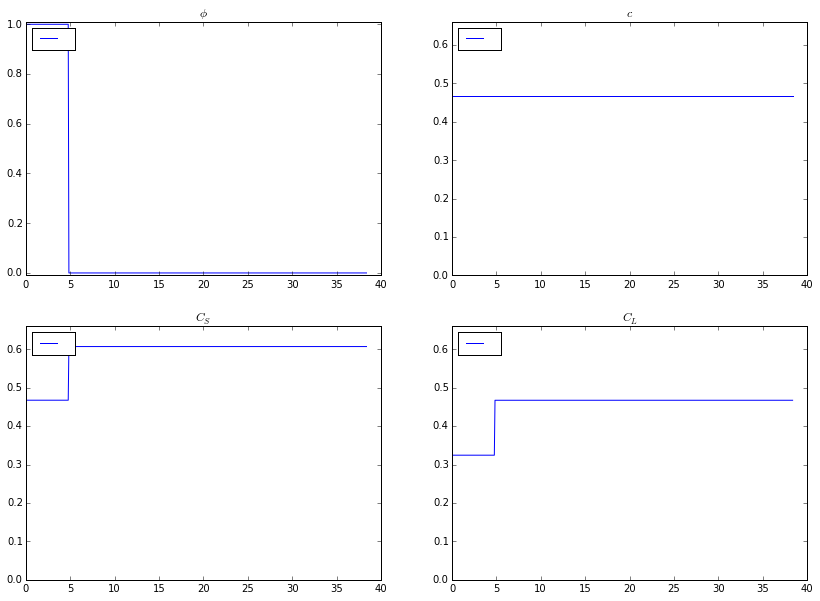

In [17]:
# Prepare new run
!rm data/FiPy/1D/dump*.npz

# Initialize grid
initPlanar(phase1, conc1, Cs1, Cl1)

# Invoke Matplotlib directly to build a 2x2 grid of images, to be populated by FiPy Viewers
fig1, ((axp1, axc1), (axs1, axl1)) = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(14,10))

# 1D viewer
viewer1 = MultiViewer(viewers = (Matplotlib1DViewer(vars=phase1, title='$\phi$', axes=axp1, \
                                                   datamin=-0.01, datamax=1.01), \
                                Matplotlib1DViewer(vars=conc1,  title='$c$'   , axes=axc1, \
                                                   datamin=0., datamax=0.66), \
                                Matplotlib1DViewer(vars=Cs1  ,  title='$C_S$' , axes=axs1, \
                                                   datamin=0., datamax=0.66), \
                                Matplotlib1DViewer(vars=Cl1  ,  title='$C_L$' , axes=axl1, \
                                                   datamin=0., datamax=0.66)))

### Set solver parameters and metadata

In [18]:
dt1 = Variable(1.0e-2) # initial timestep

currentStep1 = Variable(0) # Variables are mutable and passed by reference, integers are not.

solver1 = Solver(tolerance=1.0e-12)

totalTime1 = [0]
solidHistory1 = [(np.array(phase1.globalValue) > 0.5).sum() * dV1]
massHistory1 = [(np.array(conc1.globalValue)).sum() * dV1]
chemHistory1 = [1.0]
cflHistory1 = [epsSq * dt1.value / mesh1D.dx**2]

### Run the 1D simulation

In [19]:
# To continue from an existing simulation, execute just this and the next cell
totalSteps1 = 250000

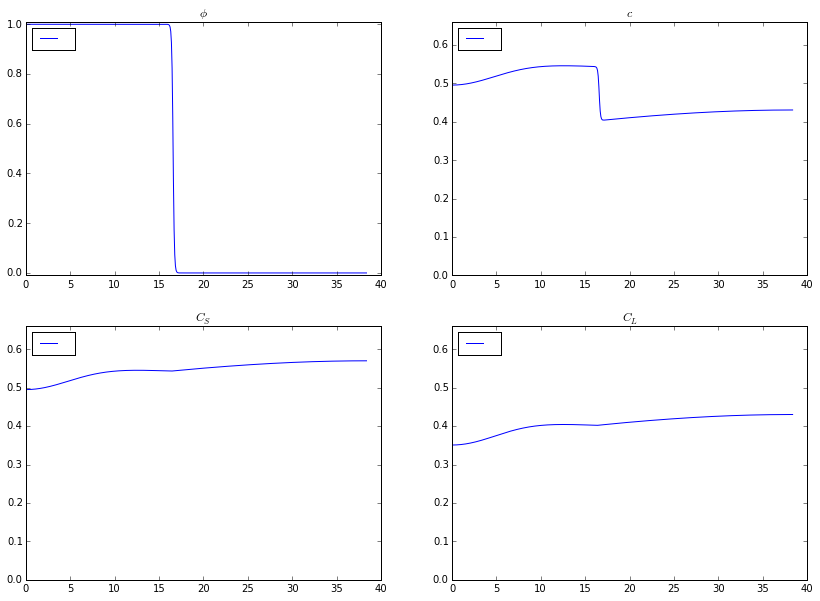

None

CPU times: user 21h 43min 32s, sys: 13min 38s, total: 21h 57min 11s
Wall time: 1d 9h 35min 1s


In [20]:
%time evolveInTime(phase1, conc1, Cs1, Cl1, viewer1, \
             phaseEq1, concEq1, solver1, dt1, dV1, \
             solidHistory1, massHistory1, chemHistory1, cflHistory1, \
             totalTime1, currentStep1, totalSteps1, \
             'data/FiPy/1D')

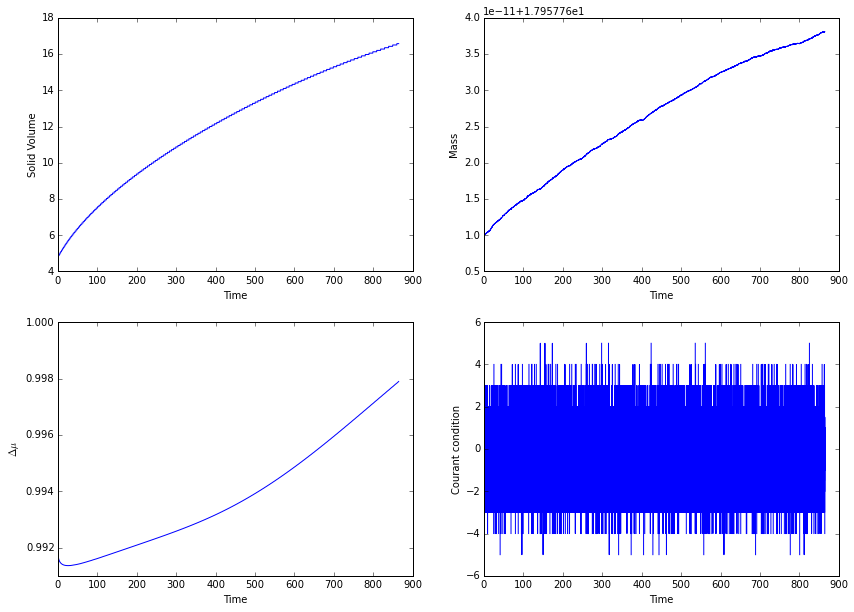

In [21]:
fig1res, ((axrs1, axrm1), (axrc1, axrv1)) = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(14,10))

axrs1.plot(totalTime1, solidHistory1)
axrs1.set_xlabel('Time')
axrs1.set_ylabel('Solid Volume')

axrm1.plot(totalTime1, massHistory1)
axrm1.set_xlabel('Time')
axrm1.set_ylabel('Mass')

axrc1.plot(totalTime1, chemHistory1)
axrc1.set_xlabel('Time')
axrc1.set_ylabel(r'$\Delta\mu$')

axrv1.plot(totalTime1, cflHistory1)
axrv1.set_xlabel('Time')
axrv1.set_ylabel('Courant condition')

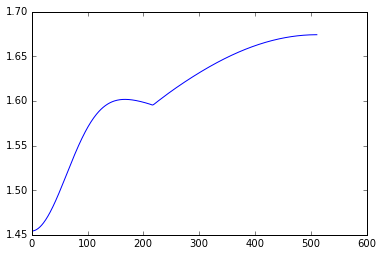

In [22]:
# Evaluate extent of solute trapping after Karma, PRE 87;11:115701 (2001)
plt.plot(Cs1/(initConc/eqPartitionCoefficient))

## More interesting: 2D

### Build the mesh, define field variables

In [24]:
# Spatial parameters
dx2 = dy2 = 0.075 # mesh resolution
nx2 = 256          # domain size
ny2 = 32

# 2D Grid
mesh2D = Grid2D(nx=nx2, ny=ny2, dx=dx2, dy=dy2)
dV2 = dx2 * dy2

# Scalar fields
phase2 = CellVariable(mesh=mesh2D, hasOld=True)
conc2  = CellVariable(mesh=mesh2D, hasOld=True)
Cs2    = CellVariable(mesh=mesh2D, hasOld=True)
Cl2    = CellVariable(mesh=mesh2D, hasOld=True)

# Equations of motion
phaseEq2 = buildPhaseEquation(phase2, Cs2, Cl2)
concEq2  = buildConcEquation(phase2, conc2, Cs2, Cl2)

### Clear old files, initialize grid and viewer

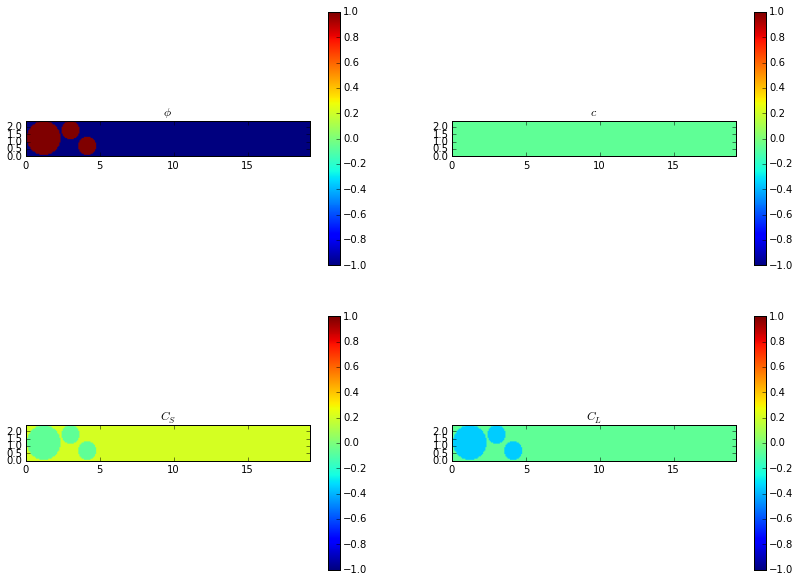

In [25]:
# Prepare new run
!rm data/FiPy/2D/dump*.npz

# Initialize grid
circles = [(     (15+1) * dx2, (ny2-1-15) * dy2, 15. * dx2), \
           (0.625 * 64 * dx2,  (ny2-1-8) * dy2,  8. * dx2), \
           (  (64-1-8) * dx2,      (1+8) * dy2,  8. * dx2)]
initCircular(phase2, conc2, Cs2, Cl2, circles)

# Invoke Matplotlib directly to build a 2x2 grid of images, to be populated by FiPy Viewers
fig2, ((axp2, axc2), (axs2, axl2)) = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(14,10))

# 2D Grid viewer
viewer2 = MultiViewer(viewers = (Matplotlib2DGridViewer(vars=phase2, title='$\phi$', axes=axp2, \
                                                       datamin=0., datamax=1.), \
                                Matplotlib2DGridViewer(vars=conc2,  title='$c$'   , axes=axc2, \
                                                       datamin=0., datamax=0.66), \
                                Matplotlib2DGridViewer(vars=Cs2  ,  title='$C_S$' , axes=axs2, \
                                                       datamin=0., datamax=0.66), \
                                Matplotlib2DGridViewer(vars=Cl2  ,  title='$C_L$' , axes=axl2, \
                                                       datamin=0., datamax=0.66) ))

### Set solver parameters and metadata

In [26]:
dt2 = Variable(1.0e-2) # initial timestep

currentStep2 = Variable(0) # Variables are mutable and passed by reference, integers are not.

solver2 = Solver(tolerance=1.0e-12)

totalTime2 = [0]
solidHistory2 = [(np.array(phase2.globalValue) > 0.5).sum() * dV2]
massHistory2 = [(np.array( conc2.globalValue)).sum() * dV2]
chemHistory2 = [1.0]
cflHistory2 = [epsSq * dt2.value / mesh2D.dx**2]

### Run the 2D simulation

In [27]:
# To continue from an existing simulation, execute just this and the next cell
totalSteps2 = 250000

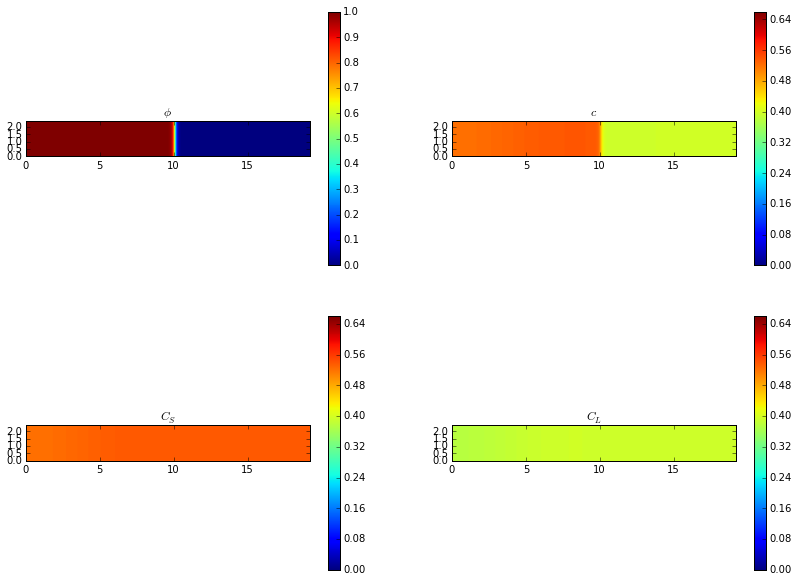

None

CPU times: user 11d 11h 23min 2s, sys: 11h 38min 55s, total: 11d 23h 1min 57s
Wall time: 2d 14h 21min 13s


In [28]:
%time evolveInTime(phase2, conc2, Cs2, Cl2, viewer2, \
                    phaseEq2, concEq2, solver2, dt2, dV2, \
                    solidHistory2, massHistory2, chemHistory2, cflHistory2, \
                    totalTime2, currentStep2, totalSteps2, \
                    'data/FiPy/2D')

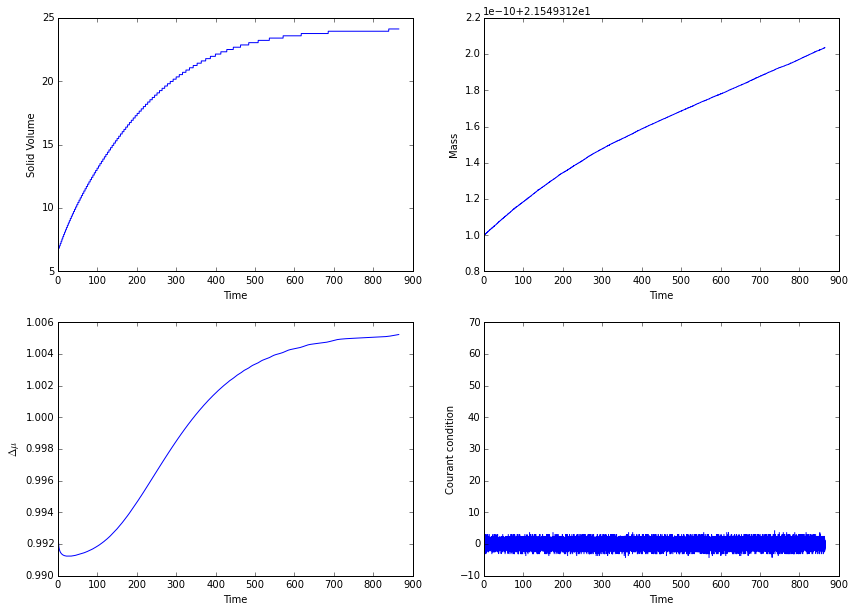

In [29]:
fig2res, ((axrs2, axrm2), (axrc2, axrv2)) = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(14,10))

axrs2.plot(totalTime2, solidHistory2)
axrs2.set_xlabel('Time')
axrs2.set_ylabel('Solid Volume')

axrm2.plot(totalTime2, massHistory2)
axrm2.set_xlabel('Time')
axrm2.set_ylabel('Mass')

axrc2.plot(totalTime2, chemHistory2)
axrc2.set_xlabel('Time')
axrc2.set_ylabel(r'$\Delta\mu$')

axrv2.plot(totalTime2, cflHistory2)
axrv2.set_xlabel('Time')
axrv2.set_ylabel('Courant condition')

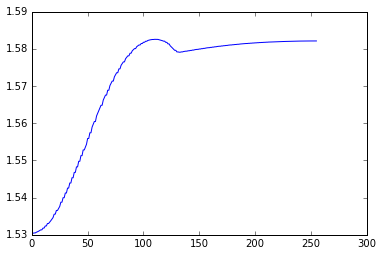

In [30]:
# Evaluate extent of solute trapping after Karma, PRE 87;11:115701 (2001)
x2 = np.arange(0,nx2*dx2,dx2)
plt.plot(Cs2((x2,int(ny2/2)))/(initConc/eqPartitionCoefficient))

In [31]:
print "FiPy: %.2f sim-time-units in %.2f wall-seconds, or %.2f seconds/unit"% \
      (37.55, (17*60 + 49), (17*60 + 49)/37.55)
print "MMSP: %.2f sim-time-units in %.2f wall-seconds, or %.2f seconds/unit"% \
      (45.0, (21*60 + 40), (21*60 + 40)/45.0)

FiPy: 37.55 sim-time-units in 1069.00 wall-seconds, or 28.47 seconds/unit
MMSP: 45.00 sim-time-units in 1300.00 wall-seconds, or 28.89 seconds/unit
